# Online GC Calibration
The purpose of calibrating an on-line GC is to obtain quantitative concentration data for your gas stream.
In order to do so, a calibration gas (mixture) is injected onto the GC. This allows us to get the relationship between the peak area and the concentration in the bottle. 
Note that when calibrating a 'conventional' GC you inject samples with different concentrations, allowing to establish a proper response factor. Since generally only one bottle is used, we are effectively doing single-point calibrations, and often rely on a plethora of other assumptions, what we are doing is not 'fine analytic chemistry'. 
The most important reason why you should calibrate is to account for drift in the detectors between experiments over longer periods of time. I have seen differences of 10% between calibrations a year apart, so take this into consideration when comparing experiments. Another important factor is that you need to use the same pressure in your calibration as your experiment, or account for the difference when analysing the data. More carbon in the injection loop = more signal.

Below I will provide examples for the calibration of two different GC systems:
- One convetional on-line GC system 

# MTO setup

For details regarding the processing of data from the on-line GC setup check the dedicated Notebook.
Here we use a bottle with components from Methane to Pentane as well as Hydrogen diluted by Nitrogen.

In [1]:
from chromstream.objects import Experiment
from chromstream.data_processing import time_window_baseline
from pathlib import Path
import pandas as pd
import chromstream.parsers as csp
import matplotlib.pyplot as plt

In [2]:
data_home = Path("../..")/"dev_data" / "chroms" /  "MTO_calibration"
paths_all = sorted((data_home).iterdir())
# Initialize an Experiment
exp_mto = Experiment("MTO_calib")

for path in paths_all:
    Chrom1, Chrom2, Chrom3 = csp.parse_MTO_asc(path)
    # Applying baseline (mean in a specified time window)
    Chrom1.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom2.apply_baseline(time_window_baseline, time_window=(288,294),inplace=True)
    Chrom3.apply_baseline(time_window_baseline, time_window=(10,15),inplace=True)
    # Adding chromatograms to the experiment
    exp_mto.add_chromatogram(Chrom1)
    exp_mto.add_chromatogram(Chrom2)
    exp_mto.add_chromatogram(Chrom3)

Briefly plotting the chromatograms:

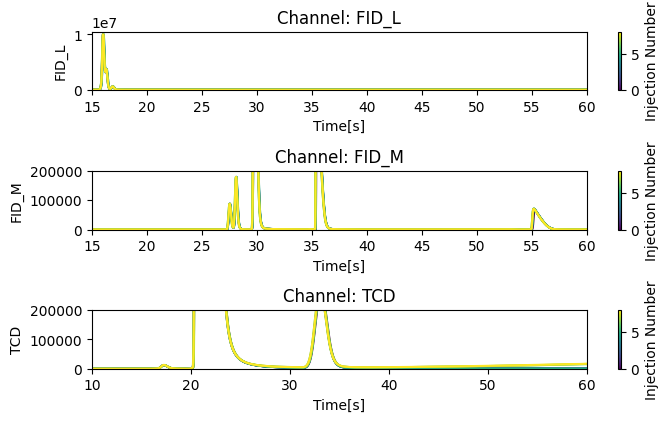

In [3]:
fig, axs = plt.subplots(3,1, figsize=(7,7/1.618))
exp_mto.plot_chromatograms(ax=axs)
plt.tight_layout()
axs[0].set_ylim(-100000,)
axs[0].set_xlim(15,60)

axs[1].set_xlim(15,60)
axs[1].set_ylim(0,200000)

axs[2].set_ylim(0,200000)
axs[2].set_xlim(10,60)
plt.show()

As you can see we have 5 peaks (5 hydrocarbons) on the middle FID colum, on the 'long' FID columns the compunds are not seperated. On the TCD channel, we see a clearly saturated Nirogen peak, as well as a small hydrogen peak.

Next, we define the peaks we want to integrate:

In [4]:
Peaks_FID_L = {
    'All_FID_L': [15, 18]
}
Peaks_FID_M = {
    'Pentane': [54, 58],
    'Butane': [34, 38],
    'Propane': [29, 34],
    'Ethane': [27.87, 29.26],
    'Methane': [27.5, 27.87],
    'ALL_products_FID_M': [26, 150]
}

Peaks_TCD = {
    'N2': [20, 26],
    'H2': [16, 19]
}


We do the integration for each channel:

In [5]:
integrals_FID_L = exp_mto.channels['FID_L'].integrate_peaks(peaklist=Peaks_FID_L,).drop(columns=['Timestamp'])
integrals_FID_M = exp_mto.channels['FID_M'].integrate_peaks(peaklist=Peaks_FID_M,).drop(columns=['Timestamp'])
integrals_TCD = exp_mto.channels['TCD'].integrate_peaks(peaklist=Peaks_TCD,).drop(columns=['Timestamp'])

peak_areas = pd.concat([integrals_FID_L, integrals_FID_M, integrals_TCD], axis=1)

We do a quick plot to see if some injections deviate signifcantly from the rest.

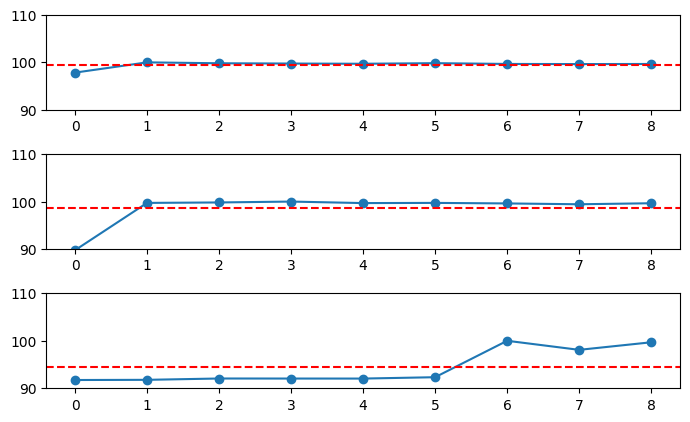

In [6]:
Fig, axs = plt.subplots(3,1, figsize=(7,7/1.618))
axs[0].plot(peak_areas.index, peak_areas['All_FID_L']/peak_areas['All_FID_L'].max()*100, 'o-')
axs[0].axhline(peak_areas['All_FID_L'].mean()/peak_areas['All_FID_L'].max()*100, color='r', linestyle='--')

axs[1].plot(peak_areas.index, peak_areas['ALL_products_FID_M']/peak_areas['ALL_products_FID_M'].max()*100, 'o-')
axs[1].axhline(peak_areas['ALL_products_FID_M'].mean()/peak_areas['ALL_products_FID_M'].max()*100, color='r', linestyle='--')

axs[2].plot(peak_areas.index, peak_areas['H2']/peak_areas['H2'].max()*100, 'o-')
axs[2].axhline(peak_areas['H2'].mean()/peak_areas['H2'].max()*100, color='r', linestyle='--')


for ax in axs:
    ax.set_ylim(90,110)
plt.tight_layout()
plt.show()

We throw out the first two and look at the mean and std dev. The the errors are too large, it could be an issue with the baseline, the peak boundries or the measurement itself.
In our case, the larger devaition for the methane peak is likely due to the poor seperation from the Ethane peak. For the other peaks, we have deviations significantly below 1%.

In [7]:
peak_areas_red = peak_areas.iloc[2:] 
# check mean, std and the relative std

results = peak_areas_red.describe(include='all').T[['mean','std']]
results['rel_std(%)'] = results['std']/results['mean']*100
results = results.sort_values('rel_std(%)')
print(results)

                            mean           std  rel_std(%)
N2                  1.974884e+07  13188.784646    0.066783
All_FID_L           3.357269e+06   2514.523884    0.074898
Pentane             6.163667e+04     97.134246    0.157592
Butane              2.726687e+05    434.329830    0.159288
Propane             6.391794e+05   1026.447373    0.160588
ALL_products_FID_M  1.045433e+06   1848.405804    0.176808
Ethane              4.610635e+04    221.736694    0.480924
H2                  1.009140e+04    409.497726    4.057888
Methane             1.500512e+04   1616.426102   10.772500


The concentrations of our calibration bottle are determined in vol%. To get a single-point calibration factor for each species, we divide the peak area by the concentration:
\begin{equation}
    CF_{vol\%} = \dfrac{A_{peak}}{c_{vol\%}}
\end{equation}

Depending the unit you need, you can first convert vol% into the unit you need. For this you can use e.g. the ideal gas law, just keep in mind its limiations.

In [8]:
bottle_content = pd.DataFrame(columns=['vol_pct'],index=['Pentane','Butane','Propane','Ethane','Methane'])
bottle_content['vol_pct'] = [0.535,2.97,9.16,0.971,1.003]
bottle_content['C_atoms'] = [5,4,3,2,1]
# for the middle channel
CF_mid = {component: (results['mean'].loc[component]/bottle_content['vol_pct'][component]) for component in bottle_content.index}
print(CF_mid)

{'Pentane': np.float64(115208.73239780453), 'Butane': np.float64(91807.6364532858), 'Propane': np.float64(69779.41050035295), 'Ethane': np.float64(47483.37169203404), 'Methane': np.float64(14960.23518124579)}


Dividing the peak area by the calibration factor above will return the concentration in vol %.
We can check how much the FID respnse changes between the molecules by accounting for the carbon number:

In [9]:
CF_per_C_atom = {component: ((results['mean'].loc[component]/bottle_content['C_atoms'][component])/bottle_content['vol_pct'][component]) for component in bottle_content.index}

cf_per_c_atom_df = pd.DataFrame.from_dict(CF_per_C_atom, orient='index', columns=['CF_per_C_atom'])
print(cf_per_c_atom_df)

         CF_per_C_atom
Pentane   23041.746480
Butane    22951.909113
Propane   23259.803500
Ethane    23741.685846
Methane   14960.235181


As you can see the FID response per carbon atom is largely similar, with the exemption of Methane.

But what if you want to analyze a compound for which you dont have a calibration mixture? In this case you can make an estimation of the concetration from the otehr compounds. In my particular use case, i wanted to get the partial pressure of 2-4 dimethyl-pentane specifically from the FID_L channel. One approach would be to determine the CF depending on the carbon number, and then extrapolate to the 7 carbon atoms of my molecule. However, as you could see in the chromatograms above, we cant really seperate the compounds on this channel. 

To still be able to get an **estimation** of the the partial pressure, we simply determine the total concentration of carbon atoms in the gas mixture als follows:
- we assume the ideal gas law holds, i.e. the vol% proporional to n%, i.e. the 
- The signal is perfectly proportial to the carbon number

In [10]:
# We determine the molar concentartion (dividing by 100) and then get the number of carbon atoms by multiplying with the carbon number
bottle_content['n(molecule)*CN'] = bottle_content['vol_pct']/100*bottle_content['C_atoms']
# the total concentartion of carbon atoms in the gas mixture
sum_n_CN = bottle_content['n(molecule)*CN'].sum()
# Getting the calibration factor per carbon atom by dividing the total signal by the total concentration
CF_CN = results.loc['All_FID_L','mean'] / sum_n_CN

print(f"Calibration factor per carbon atom: {CF_CN} ")

Calibration factor per carbon atom: 7463915.174603943 


When the peak area is divided by this calibration factor, and then divided by the number of carbon atoms in the molecule, the vol % is obtained
\begin{equation}
    c_{vol\%} = \dfrac{A_{peak}}{CF_{CN} \cdot CN}
\end{equation}

Where CN is the carbon number of the molecule.


## pyGCMS

Calibration of the pyGCMS is more complicated as the system uses sample loops (15 of them)
We load the gas mixture into all loops, and inject them one by one onto the system. The procesure is reapeated 3 times, to calibrate each loop individually.
We therefore have 3 directories (for 3 seperate runs) containing the data

In [11]:
data_home = Path("../..")/"dev_data" / "chroms" /  "pyGCMS_calibration"
dirs = sorted((data_home).iterdir())

from chromstream.data_processing import min_subtract
runs = []

for i, dir in enumerate(dirs):
    run= Experiment(f"pyGCMS_calib_run{i}")
    for chrom_path in sorted(dir.iterdir()):
        chrom = csp.parse_chromatogram_txt(chrom_path)
        # subtract the minimum as a baseline to start with
        chrom.apply_baseline(min_subtract, inplace=True)
        # adding the chromatogram to the experiment
        run.add_chromatogram(chrom)
    runs.append(run)
    


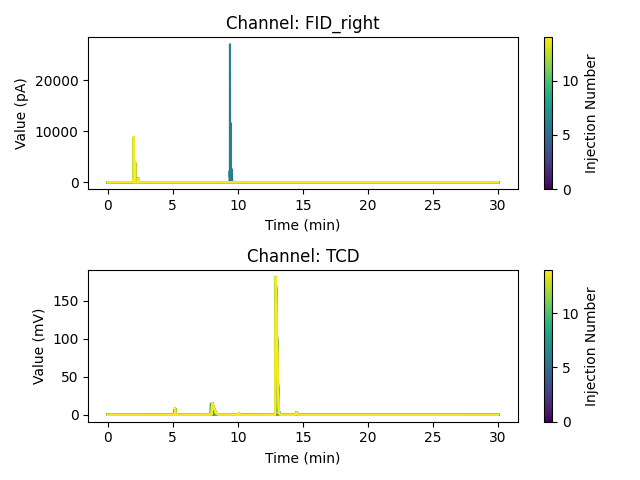

In [12]:
%matplotlib widget
runs[2].plot_chromatograms()

### FID Channel

We start with by integrating the FID channel for each experiment withing specifed bounds, then comb ining all results into one dataframe.

In [13]:
Peaks = {'Methane_Ethane':[1.93,1.99], 'Propane':[1.99,2.04], 'Butane': [2.085,2.16], 'Pentane':[2.325,2.385]}
integral_list = []
for i,exp in enumerate(runs):
    integrals = exp.channels['FID_right'].integrate_peaks(peaklist=Peaks)
    integrals = integrals.sort_values('Timestamp').reset_index(drop=True)
    integrals['Loop'] = integrals.index + 1
    integrals['run'] = i+1
    #We drop the first row as it does not work properly
    integrals = integrals.drop(index=0)
    integral_list.append(integrals)

all_integrals = pd.concat(integral_list).reset_index(drop=True)

Next we determine the mean and std deviation for each loop across the three runs

<Axes: xlabel='Loop', ylabel='Relative std (%)'>

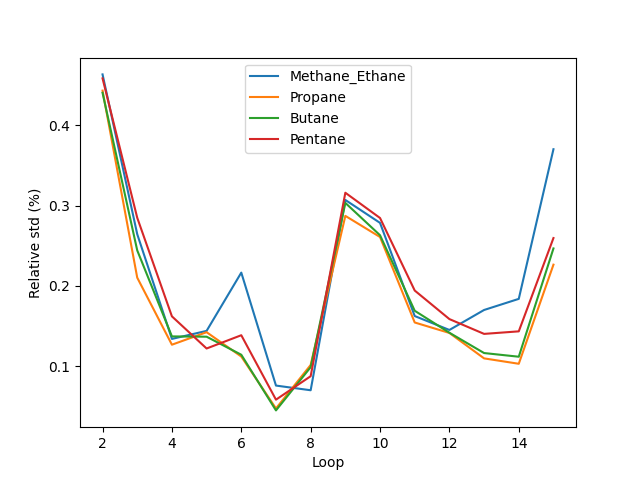

In [14]:
integrals_mean = all_integrals.groupby('Loop').mean().drop(columns=['run','Timestamp'])
integrals_std = all_integrals.groupby('Loop').std().drop(columns=['run','Timestamp'])
integrals_results_relative = integrals_std/integrals_mean*100
# if there is an entry >1, raise a warning
if (integrals_results_relative>1).any().any():
    print("Warning: Relative std. dev > 1% detected")
    
integrals_results_relative.plot(xlabel='Loop', ylabel='Relative std (%)')

As you can see the std. dev is below 1%. Next, we determine the calibration factors for each compund by dividing the known concentration by the area. Since we can not discern between Methane and Ethane on this channel, we will only utilize Propane-penate for the consecutive analysis.

In [15]:
bottle_content = pd.DataFrame(columns=['vol_pct'],index=['Pentane','Butane','Propane','Ethane','Methane'])
bottle_content['vol_pct'] = [0.535,2.97,9.16,0.971,1.003]
bottle_content['C_atoms'] = [5,4,3,2,1]

CF_vol = pd.DataFrame() # this now contains the calibration factor in units of peak_area/vol_pct
for compounds in ['Pentane','Butane','Propane']:
    CF_vol[compounds] = integrals_mean[compounds]/bottle_content['vol_pct'][compounds]


To make this analysis more general,we determine a calibration factor normalized to the carbon number. 
For this we conduct a linear regression for each loop, using the carbon number as x-axis and the CF as y axis:

In [16]:
from scipy import stats
CF_corrected = {}
Carbon_numbers = {'Pentane':5, 'Butane':4, 'Propane':3}
for loop in CF_vol.index:
    slope, intercept, r_value, p_value, std_err = stats.linregress(list(Carbon_numbers.values()), CF_vol.loc[loop, list(Carbon_numbers.keys())])
    # when there is a clear outlier, raise a warning
    if r_value < 0.99:
        print(f"Warning: r_value for loop {loop} is {r_value}, which is below 0.99")
    CF_corrected[loop] = slope  #slope is the calibration factor per carbon atom

results = pd.DataFrame.from_dict(CF_corrected, orient='index', columns=['CF_per_C_atom'])
results.index.name = 'Loop'
results.head()

,CF_per_C_atom
Loop,
2,3.649613
3,4.010493
4,4.065350
5,4.065766
6,4.067702


### TCD Channel
For the TCD channel we have the complication that we dont really have a stable baseline. Meaning that we need to specify a baseline for each peak.

In [17]:
from chromstream.data_processing import time_point_baseline


Peaks = {'Nitrogen':[12.7,14.8],'Hydrogen': [10.9,11.3], 'Propane': [7.8,9]}
baseline_points = {'Nitrogen': 12.5, 'Hydrogen': 10.9, 'Propane': [7.7]}
integral_list = []
for i,exp in enumerate(runs):
    integral_peak = {}
    for peak in Peaks:
        # apply the point baseline to a channel
        exp.channels['TCD'].apply_baseline(time_point_baseline, time_point=baseline_points[peak], inplace=True, suffix=f"_BL_t{baseline_points[peak]}")
        integrals = exp.channels['TCD'].integrate_peaks({peak: Peaks[peak]})
        integral_peak[peak] = integrals

    integrals = pd.concat(integral_peak.values(), axis=1)
    integrals = integrals.loc[:,~integrals.columns.duplicated()]#drop duplicate Timestamp columns
    integrals = integrals.sort_values('Timestamp').reset_index(drop=True)
    integrals['Loop'] = integrals.index + 1
    integrals['run'] = i+1
    
    #We drop the first row as it does not work properly
    integrals = integrals.drop(index=0)
    integral_list.append(integrals)

all_integrals = pd.concat(integral_list).reset_index(drop=True)
all_integrals.head()

,Timestamp,Nitrogen,Hydrogen,Propane,Loop,run
0,2025-01-14 14:09:55,22.920375,0.006642,2.757142,2,1
1,2025-01-14 14:41:08,24.835361,0.007078,3.030840,3,1
2,2025-01-14 15:11:33,24.977383,0.006926,3.055321,4,1
3,2025-01-14 15:41:56,24.929261,0.007205,3.050116,5,1
4,2025-01-14 16:12:20,24.990309,0.007169,3.058718,6,1


<Axes: xlabel='Loop', ylabel='Relative std (%)'>

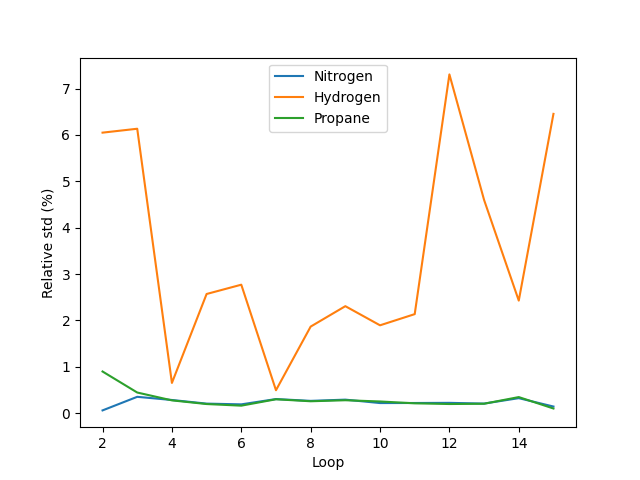

In [18]:
integrals_mean = all_integrals.groupby('Loop').mean().drop(columns=['run','Timestamp'])
integrals_std = all_integrals.groupby('Loop').std().drop(columns=['run','Timestamp'])
integrals_results_relative = integrals_std/integrals_mean*100
# if there is an entry >1, raise a warning
if (integrals_results_relative>1).any().any():
    print("Warning: Relative std. dev > 1% detected")
    
integrals_results_relative.plot(xlabel='Loop', ylabel='Relative std (%)')

The standard dev for hydrogen is rather high, might need to tune the integration

In [19]:
bottle_content = pd.DataFrame(columns=['vol_pct'],index=['Nitrogen','Hydrogen','Propane'])
bottle_content['vol_pct'] = [84.356, 1.005, 9.16]


CF_vol = pd.DataFrame() # this now contains the calibration factor in units of peak_area/vol_pct
for compounds in ['Nitrogen','Hydrogen','Propane']:
    CF_vol[compounds] = integrals_mean[compounds]/bottle_content['vol_pct'][compounds]

CF_vol.head()

,Nitrogen,Hydrogen,Propane
Loop,,,
2,0.271879,0.006178,0.304144
3,0.295574,0.007140,0.332513
4,0.296890,0.006903,0.334392
5,0.296229,0.007274,0.333739
6,0.296760,0.007343,0.334424
